#Machine Prep

In [ ]:
%%bash
apt install graphviz libgraphviz-dev

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2

In [ ]:
%%bash
pip -q install networkx pygraphviz powerlaw pandas > /dev/null 2>&1 || true

In [ ]:
import networkx as nx, matplotlib.pyplot as plt, pandas as pd, numpy as np, random, powerlaw
from collections import defaultdict
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

#Pedigree Helpers

In [ ]:
def ped_to_graph(ped_path):
    cols = ['fam','id','dad','mom','sex','phen']
    # read everything as string to avoid implicit ints
    df = pd.read_csv(ped_path, sep=r'\s+', header=None, names=cols, dtype=str)

    G = nx.DiGraph()
    for _, r in df.iterrows():
        G.add_node(
            r['id'],
            family=r['fam'],
            sex=int(r['sex']),
            phenotype=int(r['phen'])
        )
    for _, r in df.iterrows():
        if r['dad'] != '0':
            G.add_edge(r['dad'], r['id'])
        if r['mom'] != '0':
            G.add_edge(r['mom'], r['id'])
    return G

#brought over from PedigreeGenerator
def df_to_graph(df):
    G = nx.DiGraph()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)

    return G


def graphviz_pos(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog='dot')
    except Exception:
        return nx.spring_layout(G, seed=42)

#Brought over from PedigreeGenerator
def plot_pedigree_df(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

def plot_pedigree(G, title="Pedigree"):
    pos = graphviz_pos(G)
    colors = ['red' if G.nodes[n].get('phenotype',0)==2 else 'lightblue' for n in G]
    nx.draw(G, pos, node_color=colors, with_labels=True, arrows=True)
    plt.title(title)
    plt.show()

# ---------------- pedigree helper utilities -----------------
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl
# ------------------------------------------------------------

#Pedigree Simulation

In [ ]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)

ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

156

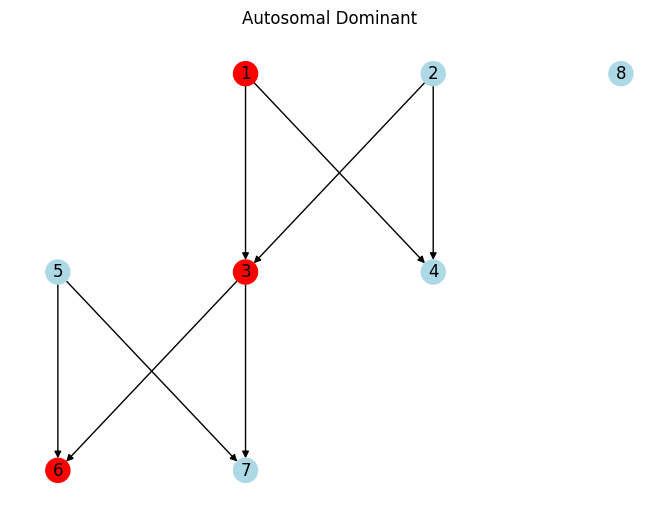

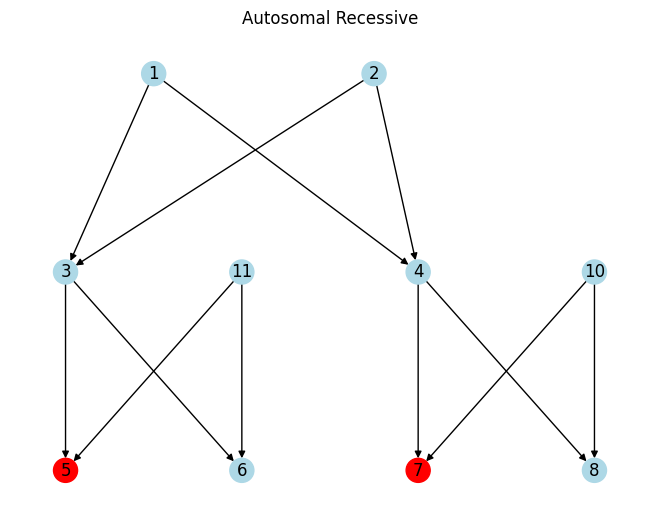

In [ ]:
G_ad = ped_to_graph('ad_complete.ped')
G_ar = ped_to_graph('ar_complete.ped')
plot_pedigree(G_ad, 'Autosomal Dominant')
plot_pedigree(G_ar, 'Autosomal Recessive')

#Pedigree Generator

In [ ]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, AffectedSpouse= False, BackpropLikelihood= False, alt_freq= 0):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

#Pedigree Classification

In [95]:
import numpy as np
import powerlaw
import itertools as it
from math import log10
from collections import OrderedDict

from collections import OrderedDict
import networkx as nx, numpy as np, powerlaw
import statistics as st

def graph_metrics(G):
    """Return an OrderedDict of network statistics; robust to disconnected graphs."""
    G_u = G.to_undirected()
    metrics = OrderedDict()

    # ---------- basic sizes ----------
    metrics['n_nodes']   = G.number_of_nodes()
    metrics['n_edges']   = G.number_of_edges()
    metrics['n_components'] = nx.number_connected_components(G_u)

    # ---------- centralities (averaged over ALL nodes) ----------
    deg_cent  = list(nx.degree_centrality(G_u).values())
    bet_cent  = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())
    metrics['avg_degree_centrality'] = float(np.mean(deg_cent))
    metrics['avg_betweenness']       = float(np.mean(bet_cent))
    metrics['avg_closeness']         = float(np.mean(clos_cent))

    # ---------- clustering ----------
    metrics['avg_clustering'] = nx.average_clustering(G_u)

    # ---------- choose a CORE (largest connected component) for path-metrics ----------
    core = G_u

    # ---------- diameter & average path on CORE ----------
    metrics['diameter'] = nx.diameter(core)
    metrics['avg_path_len'] = nx.average_shortest_path_length(core)

    # ---------- small-world sigma (CORE vs random ER) ----------
    #opted of plug-and-play sigma calculation from NetworkX over first principals calculation
    #parameters greatly lowered for threshold determination efficiency
    metrics['sigma_small_world'] = nx.sigma(core, niter= 1, nrand= 1)


    # ---------- power-law exponent on full graph ----------
    degs = [d for _, d in G_u.degree()]
    fit = powerlaw.Fit(degs, discrete=True, verbose=False)
    metrics['pl_alpha'] = round(fit.power_law.alpha, 3)
    metrics['pl_xmin']  = fit.power_law.xmin


    return metrics

In [ ]:
def pedigree_features(G):

    phen = nx.get_node_attributes(G,'phenotype')
    aff_nodes = [n for n,p in phen.items() if p==2]
    unaff_nodes = [n for n,p in phen.items() if p!=2]

    # ratio affected with affected parent
    aff_aff_parent = 0
    for n in aff_nodes:
        if any(phen.get(p,0)==2 for p in parents(G,n)):
            aff_aff_parent +=1
    ratio_aff_parent = aff_aff_parent/len(aff_nodes) if aff_nodes else 0

    # generation coverage
    gen = generations(G)
    gens_aff = {gen[n] for n in aff_nodes}
    gen_cov = len(gens_aff)/(max(gen.values())+1) if gen else 0

    # sibling clustering
    sib_pairs=0; aa_pairs=0
    for n in aff_nodes:
        for sib in siblings(G,n):
            if sib in aff_nodes:
                aa_pairs+=1
            sib_pairs+=1
    sibling_aff_ratio = aa_pairs/sib_pairs if sib_pairs else 0

    # betweenness carriers
    bet = nx.betweenness_centrality(G)
    carrier = [n for n in unaff_nodes if G.nodes[n].get('phenotype')!=2 and G.nodes[n].get('genotype') != 0]
    avg_bet_carrier = np.mean([bet[n] for n in carrier]) if carrier else 0
    avg_bet_unaff = np.mean([bet[n] for n in unaff_nodes]) if unaff_nodes else 0

    #new betweeness of carriers (with graph of only affected and carriers)
    new_bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier))
    new_avg_bet_carrier = np.mean([new_bet[n] for n in carrier]) if carrier else 0


    return dict(ratio_aff_parent=ratio_aff_parent, gen_cov=gen_cov, sibling_aff_ratio=sibling_aff_ratio, avg_bet_carrier=avg_bet_carrier, avg_bet_unaff=avg_bet_unaff, new_avg_bet_carrier=new_avg_bet_carrier)

def classify_inheritance_simple(G):
    feats = pedigree_features(G)
    if feats['ratio_aff_parent']>=(7/12) or feats['sibling_aff_ratio']>=(7.625/12):
        return 'AD',feats
    elif feats['ratio_aff_parent']<=(2.5/12) or feats['sibling_aff_ratio']<=(2.625/12):
        return 'AR',feats
    else:
        return 'Uncertain',feats

mode_ad, feats_ad = classify_inheritance_simple(G_ad)
mode_ar, feats_ar = classify_inheritance_simple(G_ar)
print('Predicted mode AD pedigree:', mode_ad, feats_ad)
print('Predicted mode AR pedigree:', mode_ar, feats_ar)


Predicted mode AD pedigree: AD {'ratio_aff_parent': 0.6666666666666666, 'gen_cov': 1.0, 'sibling_aff_ratio': 0.0, 'avg_bet_carrier': np.float64(0.0), 'avg_bet_unaff': np.float64(0.0), 'new_avg_bet_carrier': np.float64(0.0)}
Predicted mode AR pedigree: AR {'ratio_aff_parent': 0.0, 'gen_cov': 0.5, 'sibling_aff_ratio': 0.0, 'avg_bet_carrier': np.float64(0.013888888888888888), 'avg_bet_unaff': np.float64(0.013888888888888888), 'new_avg_bet_carrier': np.float64(0.013888888888888888)}


#Pedigree Classification Optimization

##Attempted Manual Classifier Optimization
Working from first principles (likelihood of particular mendelian inheritence patterns)

In [ ]:
def pedigree_classifier_test(trials= 10):
    trial_result = {}
    trial_results_df = pd.DataFrame(columns= ['FamilyID', 'Actual_Mode', 'Test_Pass'])
    for test_num in range(1,trials+1):
        famID = 'Fam' + str(test_num)
        actual_mode = random.choices(population= ['AD', 'AR'], weights= [1, 1])[0]
        trial_result['FamilyID'] = famID
        trial_result['Actual_Mode']= actual_mode
        trial_df = pedigree_generator(FamilyID= famID,
                                      mode= actual_mode,
                                      max_children= random.randint(2,5),
                                      generation_count= random.randint(2,4),
                                      AffectedSpouse= True,
                                      BackpropLikelihood= random.choice([0, 0.25, 0.5, 0.75, 1]),
                                      alt_freq= random.randint(1,20)/100)
        test_dg = df_to_graph(trial_df)
        predicted_mode, _ = classify_inheritance_simple(test_dg)

        if predicted_mode == 'Uncertain':
            trial_result['Test_Pass'] = 'Uncertain'
        elif predicted_mode == actual_mode:
            trial_result['Test_Pass'] = 'Pass'
        else:
            trial_result['Test_Pass'] = 'Fail'
        new_result = pd.DataFrame(trial_result, index= [0])
        trial_results_df = pd.concat(objs= [trial_results_df, new_result], ignore_index=True)
    return trial_results_df


In [ ]:
manual_classifier_test = pedigree_classifier_test(trials=100)
uncertain_results = manual_classifier_test[manual_classifier_test['Test_Pass']=='Uncertain']
pass_results = manual_classifier_test[manual_classifier_test['Test_Pass']=='Pass']
fail_results = manual_classifier_test[manual_classifier_test['Test_Pass']=='Fail']
print('Number of Uncertain Results:', len(uncertain_results))
print('Number of Pass Results:', len(pass_results))
print('Number of Fail Results:', len(fail_results))

Number of Uncertain Results: 9
Number of Pass Results: 72
Number of Fail Results: 19


##Decision Tree Classifier Optimization

Graph Data Generation

In [94]:
def dag_feature_generation(number_entries= 5):

    #dataframe to hold each trial entry graph features
    dag_features_df = pd.DataFrame(columns= ['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrer', 'avg_bet_unaff', 'new_avg_bet_carrier', 'mode'])

    for i in range(number_entries):
        FamilyID = 'Fam' + str(i+1)
        trialMode = random.choice(['AR','AD'])
        trial_df = pedigree_generator(FamilyID= FamilyID,
                                      mode= trialMode,
                                      max_children= random.randint(2,5),
                                      generation_count= random.randint(2,4),
                                      AffectedSpouse= True,
                                      BackpropLikelihood= random.choice([0, 0.25, 0.5, 0.75, 1]),
                                      alt_freq= random.randint(1,20)/100)
        trial_dg = df_to_graph(trial_df)
        trial_features_df = pd.DataFrame(pedigree_features(trial_dg), index=[0])
        trial_features_df['mode'] = trialMode
        dag_features_df = pd.concat(objs= [dag_features_df, trial_features_df], ignore_index=True)

    return dag_features_df

test_dag_feature_df = dag_feature_generation(number_entries= 500)
tree_features = test_dag_feature_df[['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'new_avg_bet_carrier']]
tree_labels = test_dag_feature_df['mode']

threshold_dtree = tree.DecisionTreeClassifier(max_depth=2)
threshold_dtree.fit(tree_features, tree_labels)

tree.plot_tree(threshold_dtree, feature_names= tree_features.columns)

/tmp/ipython-input-94-1704487124.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dag_features_df = pd.concat(objs= [dag_features_df, trial_features_df], ignore_index=True)


KeyboardInterrupt: 

##Individual Feature Threshold Analysis

Try adjusting the above code to isolate each metric and find the optimal threshold for each, in isolation of the others, then combine with 'or' statements.

In [ ]:
from sklearn.metrics import accuracy_score

def feature_data_generation(trials= 10):
    trial_result = {}
    all_trial_feats_df = pd.DataFrame(columns= ['actual_mode', 'ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_unaff', 'new_avg_bet_carrier'])
    for test_num in range(1,trials+1):
        famID = 'Fam' + str(test_num)
        actual_mode = random.choices(population= ['AD', 'AR'], weights= [1, 1])[0]

        #generate trial pedigree
        trial_df = pedigree_generator(FamilyID= famID,
                                      mode= actual_mode,
                                      max_children= random.randint(2,5),
                                      generation_count= random.randint(3,5),
                                      AffectedSpouse= True,
                                      BackpropLikelihood= random.choice([0.5, 0.75, 1]),
                                      alt_freq= random.randint(1,10)/100)

        trial_dg = df_to_graph(trial_df)
        trial_feat_dict = pedigree_features(trial_dg)
        trial_feat_dict['FamilyID'] = famID
        trial_feat_dict['actual_mode']= actual_mode
        trial_feat_df = pd.DataFrame(trial_feat_dict, index= [0])

        all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_feat_df], ignore_index=True)

    return all_trial_feats_df



def param_best_threshold(feature_values, actual_labels):


    #determine range and poarticular thresholds to be tested
    min_value = min(feature_values)
    max_value = max(feature_values)
    thresh_increment = (max_value - min_value)/100
    possible_thresholds = []
    for i in range(101):
        possible_thresholds.append(min_value + (i*thresh_increment))

    #set defaults for threshold search
    best_threshold = None
    best_accuracy = 0
    direction = None

    #search for best threshold (accounting for greater or less_equal possibilities for classfication relative to AD)
    for threshold in possible_thresholds:
        greater_prediction = ['AD' if value > threshold else 'AR' for value in feature_values]
        less_equal_prediction = ['AD' if value <= threshold else 'AR' for value in feature_values]

        greater_accuracy = accuracy_score(actual_labels, greater_prediction)
        less_equal_accuracy = accuracy_score(actual_labels, less_equal_prediction)

        if greater_accuracy > best_accuracy:
            best_accuracy = greater_accuracy
            best_threshold = threshold
            direction = 'greater'
        elif less_equal_accuracy > best_accuracy:
            best_accuracy = less_equal_accuracy
            best_threshold = threshold
            direction = 'less_equal'

    return best_threshold, direction, best_accuracy

def multifeature_threshold_determination(feature_df, chosen_features):
    thresholds = {}
    for feature in chosen_features:
        threshold, direction, accuracy = param_best_threshold(feature_df[feature].values, feature_df['actual_mode'].values)
        thresholds[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
    return thresholds

def confidence_score_classification(features, thresholds):
    votes = 0
    total = 0

    for feature, descriptors in thresholds.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        if accuracy >= 0.75:
            feature_value = features[feature]
            total += 1

            if direction == 'greater':
                if feature_value > threshold:
                    votes += 1
            elif direction == 'less_equal':
                if feature_value <= threshold:
                    votes += 1

    confidence_score = votes/total

    if confidence_score > 0.75:
        return 'AD'
    elif confidence_score < 0.25:
        return 'AR'
    else:
        return 'Uncertain'


In [ ]:
import pprint
generated_features_df = feature_data_generation(trials= 500)
chosen_features = ['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'new_avg_bet_carrier']
best_thresholds = multifeature_threshold_determination(generated_features_df, chosen_features)
pprint.pprint(best_thresholds)
predicted_mode_field = []
for _, row in generated_features_df.iterrows():
    predicted_mode = confidence_score_classification(row, best_thresholds)
    predicted_mode_field.append(predicted_mode)
generated_features_df['predicted_mode'] = predicted_mode_field
certain_results = generated_features_df[generated_features_df['predicted_mode']!='Uncertain']
print('Number of Certain Results: ' + str(len(certain_results)) + '/500')
print('Confidence Score Multi-threshold Classification Accuracy: ' + str(accuracy_score(certain_results['actual_mode'], certain_results['predicted_mode'])))


/tmp/ipython-input-9-953659953.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_feat_df], ignore_index=True)


{'gen_cov': {'accuracy': 0.828,
             'direction': 'greater',
             'threshold': np.float64(0.6)},
 'new_avg_bet_carrier': {'accuracy': 0.528,
                         'direction': 'less_equal',
                         'threshold': np.float64(0.005714285714285714)},
 'ratio_aff_parent': {'accuracy': 0.922,
                      'direction': 'greater',
                      'threshold': np.float64(0.20159999999999997)},
 'sibling_aff_ratio': {'accuracy': 0.8,
                       'direction': 'greater',
                       'threshold': np.float64(0.35000000000000003)}}
Number of Certain Results: 372/500
Confidence Score Multi-threshold Classification Accuracy: 0.9489247311827957


##Pedigree Size-specific Threshold Analysis

To Do:
*   Avoiding Sparse Pedigrees




In [116]:
from sklearn.metrics import accuracy_score
import pprint
import matplotlib.pyplot as plt

def feature_data_generation(generation_count, trials):
    trial_result = {}
    all_trial_feats_df = pd.DataFrame(columns= ['actual_mode', 'ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_unaff', 'new_avg_bet_carrier',
                                                'n_nodes', 'n_edges', 'n_components',
                                                'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                                'avg_clustering', 'diameter', 'avg_path_len',
                                                'sigma_small_world', 'pl_alpha', 'pl_xmin'])
    for test_num in range(1,trials+1):
        famID = 'Fam' + str(test_num)
        actual_mode = random.choices(population= ['AD', 'AR'], weights= [1, 1])[0]
        alt_freq = random.randint(2,10)/100 if actual_mode == 'AD' else random.randint(5,25)/100
        #generate trial pedigree
        trial_df = pedigree_generator(FamilyID= famID,
                                      mode= actual_mode,
                                      max_children= random.randint(2,5),
                                      generation_count= generation_count,
                                      AffectedSpouse= True,
                                      BackpropLikelihood= random.choice([0.25, 0.5, 0.75]),
                                      alt_freq= alt_freq)

        trial_dg = df_to_graph(trial_df)

        trial_feat_dict = pedigree_features(trial_dg)
        trial_feat_dict['actual_mode']= actual_mode
        trial_metrics_dict = graph_metrics(trial_dg)
        #union of features dictionary and metrics dictionary
        trial_feat_and_metrics_dict = {**trial_feat_dict, **trial_metrics_dict}
        trial_df = pd.DataFrame(trial_feat_and_metrics_dict, index= [0])

        all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)

    return all_trial_feats_df


def roc_param_calc(true_labels, predicted_labels):
    real_pos_count = 0
    real_neg_count = 0
    true_pos_count = 0
    false_pos_count = 0

    for i in range(len(true_labels)):
        if true_labels[i] == 'AD':
            real_pos_count += 1
            if predicted_labels[i] == 'AD':
                true_pos_count += 1
        elif true_labels[i] == 'AR':
            real_neg_count += 1
            if predicted_labels[i] == 'AD':
                false_pos_count += 1


    tpr = true_pos_count/real_pos_count
    fpr = false_pos_count/real_neg_count

    return tpr, fpr


def param_best_threshold(feature_values, actual_labels):

    #determine range and poarticular thresholds to be tested
    min_value = min(feature_values)
    max_value = max(feature_values)
    thresh_increment = (max_value - min_value)/100
    possible_thresholds = []
    for i in range(102):
        possible_thresholds.append(min_value-thresh_increment + (i*thresh_increment))

    #set defaults for threshold search
    best_threshold = None
    best_accuracy = 0
    direction = None

    tpr_list = []
    fpr_list = []
    #search for best threshold (accounting for greater or less_equal possibilities for classfication relative to AD)
    for threshold in possible_thresholds:
        greater_prediction = ['AD' if value > threshold else 'AR' for value in feature_values]
        less_equal_prediction = ['AD' if value <= threshold else 'AR' for value in feature_values]

        greater_accuracy = accuracy_score(actual_labels, greater_prediction)
        less_equal_accuracy = accuracy_score(actual_labels, less_equal_prediction)


        tpr, fpr = roc_param_calc(actual_labels, greater_prediction)

        tpr_list.append(tpr)
        fpr_list.append(fpr)


        if greater_accuracy > best_accuracy:
            best_accuracy = greater_accuracy
            best_threshold = threshold
            direction = 'greater'

        elif less_equal_accuracy > best_accuracy:
            best_accuracy = less_equal_accuracy
            best_threshold = threshold
            direction = 'less_equal'


    return best_threshold, direction, best_accuracy, tpr_list, fpr_list

def roc_plot(feature, tpr, fpr):
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{feature} ROC Curve')
    plt.grid(True)
    plt.show()

def multifeature_threshold_determination(feature_df, chosen_features):
    thresholds = {}
    for feature in chosen_features:
        threshold, direction, accuracy, tpr, fpr = param_best_threshold(feature_df[feature].values, feature_df['actual_mode'].values)
        thresholds[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
        roc_plot(feature, tpr, fpr)
    return thresholds

def confidence_score_classification(features, thresholds):
    votes = 0
    total = 0

    for feature, descriptors in thresholds.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        feature_value = features[feature]
        total += 1

        if direction == 'greater':
            if feature_value > threshold:
                votes += 1
        elif direction == 'less_equal':
            if feature_value <= threshold:
                votes += 1

    confidence_score = votes/total

    if confidence_score > 0.75:
        return 'AD'
    elif confidence_score < 0.25:
        return 'AR'
    else:
        return 'Uncertain'

def size_specific_threshold_determination(feature_options, trials_count, generation_range):
    min_generation_count = generation_range[0]
    max_generation_count = generation_range[1]
    all_thresholds = {}
    accurate_thresholds = {}
    testing_feature_tables = {}
    for generation_count in range(min_generation_count, max_generation_count+1):
        trial_generated_features = feature_data_generation(generation_count= generation_count,
                                                            trials= trials_count)
        #TRAINING vs TESTING split
        training_features = trial_generated_features.sample(frac=0.8)
        testing_features = trial_generated_features.drop(training_features.index)

        all_size_specific_thresholds = multifeature_threshold_determination(feature_df= training_features,
                                                                            chosen_features= feature_options)

        all_thresholds[generation_count] = all_size_specific_thresholds

        print('\n\nGENERATIONS = ' + str(generation_count))
        print('THRESHOLDS (pre-confidence score culling)')
        pprint.pprint(all_size_specific_thresholds)

        accurate_size_specific_thresholds = {}
        for feature in all_size_specific_thresholds.keys():
            if all_size_specific_thresholds[feature]['accuracy'] >= 0.75:
                accurate_size_specific_thresholds[feature] = all_size_specific_thresholds[feature]

        accurate_thresholds[generation_count] = accurate_size_specific_thresholds

        predicted_mode_field = []
        for _,row in testing_features.iterrows():
            predicted_mode = confidence_score_classification(row, accurate_size_specific_thresholds)
            predicted_mode_field.append(predicted_mode)
        testing_features['predicted_mode'] = predicted_mode_field

        testing_feature_tables[generation_count] = testing_features

        certain_results_df = testing_features[testing_features['predicted_mode']!='Uncertain']
        print('Number of Certain Results: ' + str(len(certain_results_df)) + '/' + str(int(0.2*trials_count)))
        print('Classification Accuracy: ' + str(accuracy_score(certain_results_df['actual_mode'], certain_results_df['predicted_mode'])) + '\n')

    #return all_thresholds, accurate_thresholds, testing_feature_tables


###Classification Test

/tmp/ipython-input-116-4004576428.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)


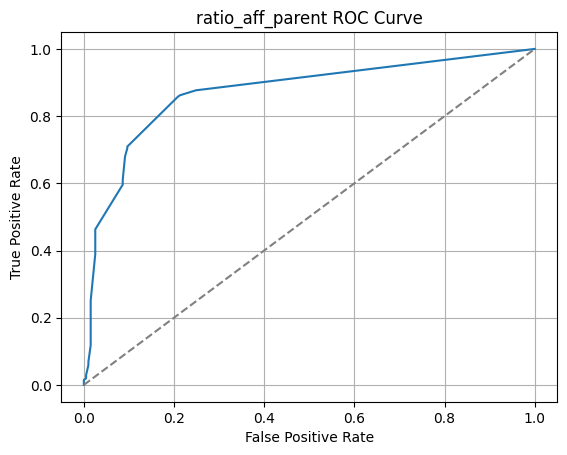

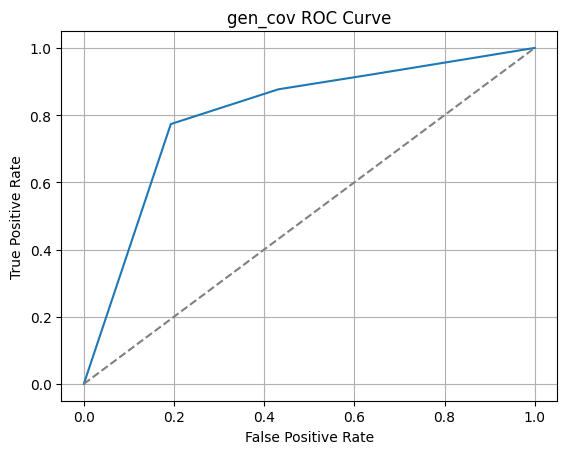

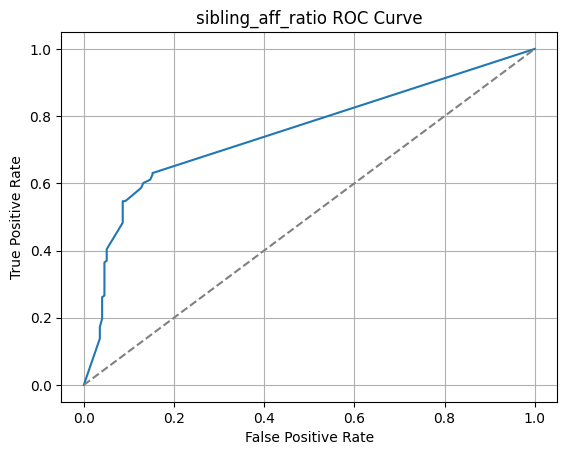

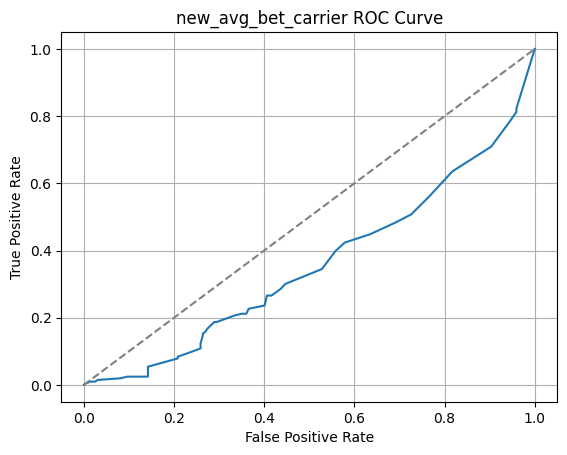

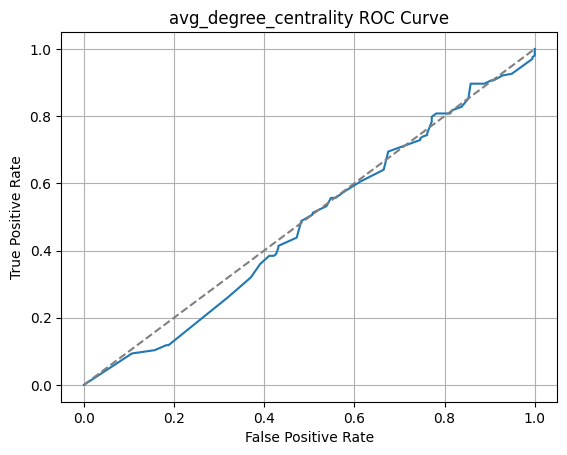

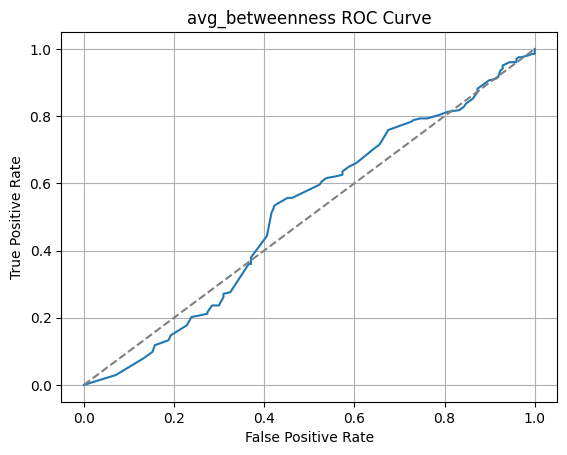

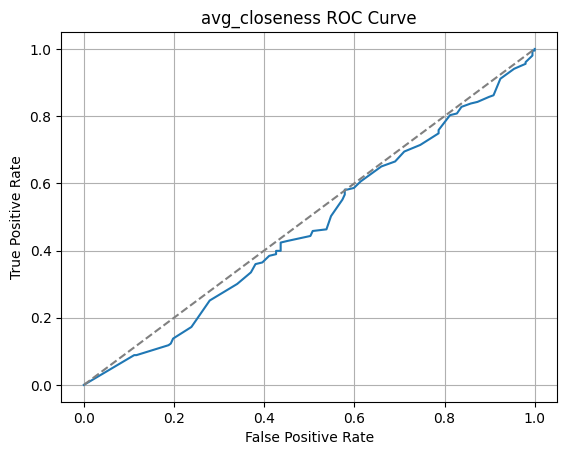

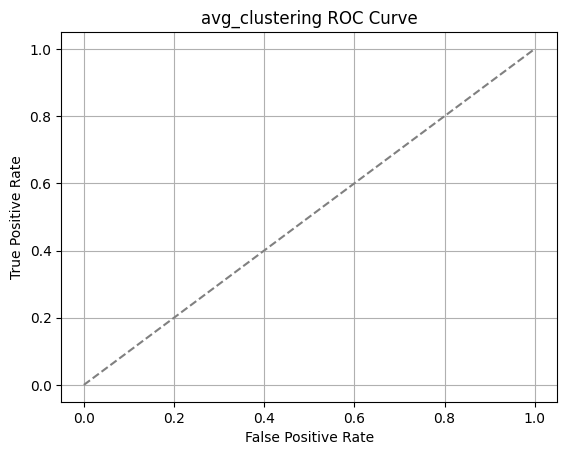

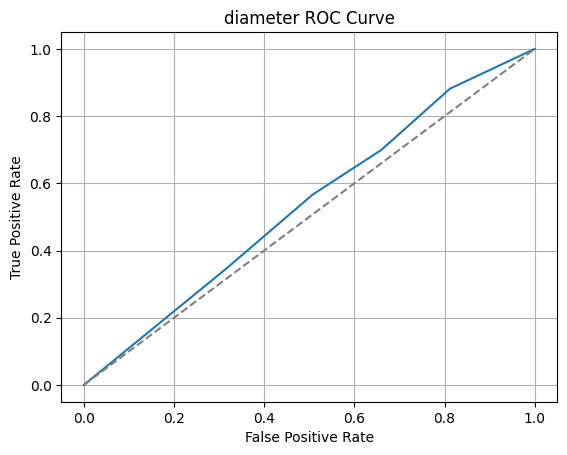

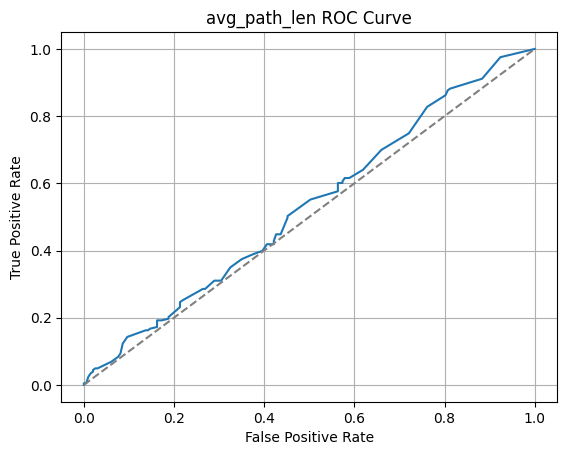

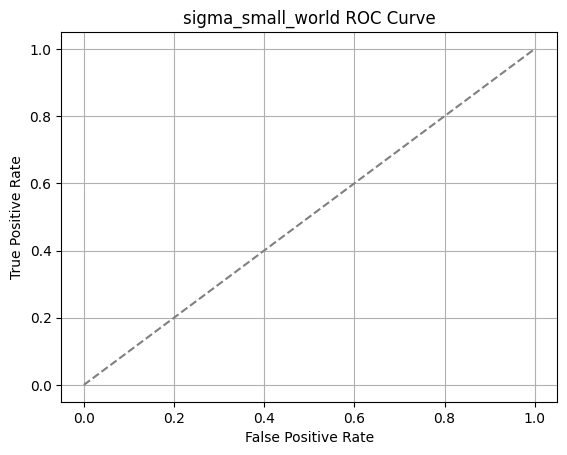

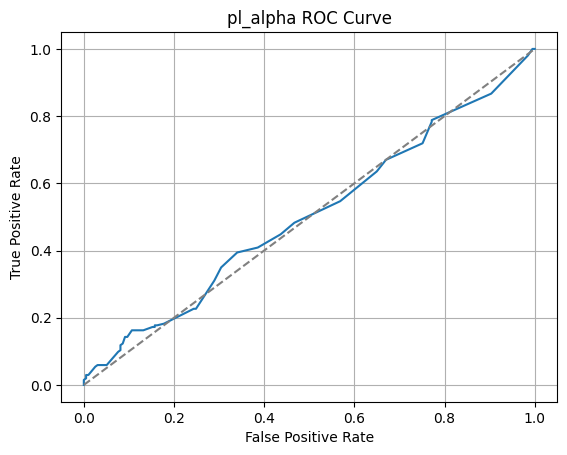

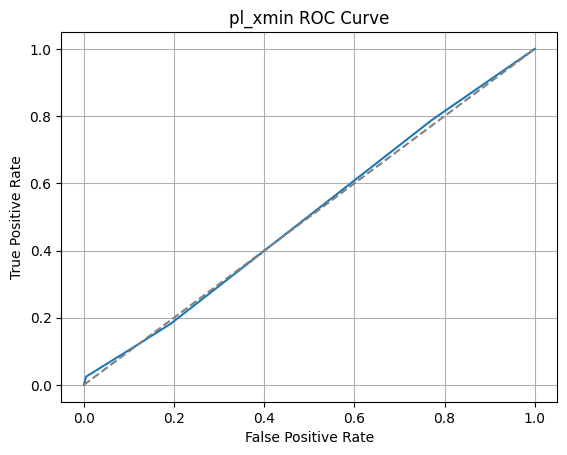



GENERATIONS = 3
THRESHOLDS (pre-confidence score culling)
{'avg_betweenness': {'accuracy': 0.555,
                     'direction': 'greater',
                     'threshold': np.float64(0.1728931788931789)},
 'avg_closeness': {'accuracy': 0.54,
                   'direction': 'less_equal',
                   'threshold': np.float64(0.5186300421377632)},
 'avg_clustering': {'accuracy': 0.5075,
                    'direction': 'less_equal',
                    'threshold': np.float64(0.0)},
 'avg_degree_centrality': {'accuracy': 0.54,
                           'direction': 'less_equal',
                           'threshold': np.float64(0.2883783783783784)},
 'avg_path_len': {'accuracy': 0.54,
                  'direction': 'greater',
                  'threshold': np.float64(1.819047619047619)},
 'diameter': {'accuracy': 0.54, 'direction': 'greater', 'threshold': 3.0},
 'gen_cov': {'accuracy': 0.79,
             'direction': 'greater',
             'threshold': np.float64(0.6666666

/tmp/ipython-input-116-4004576428.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)


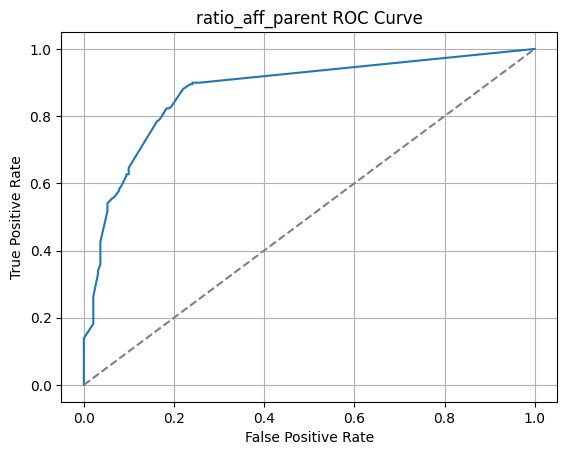

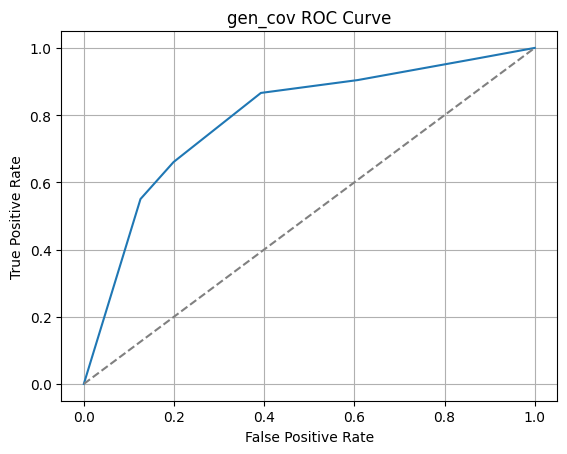

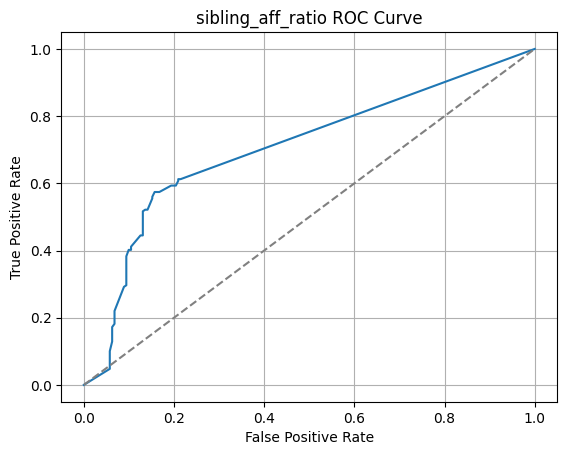

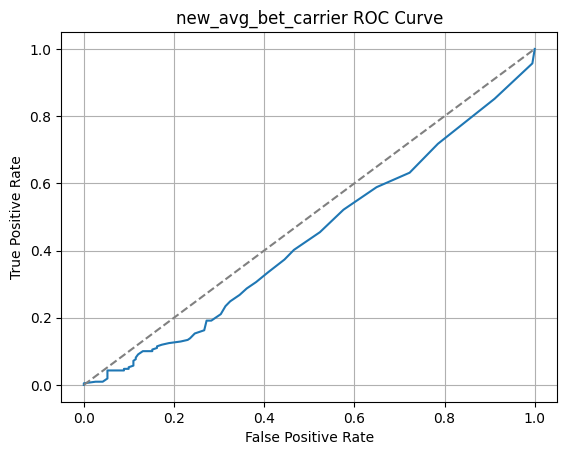

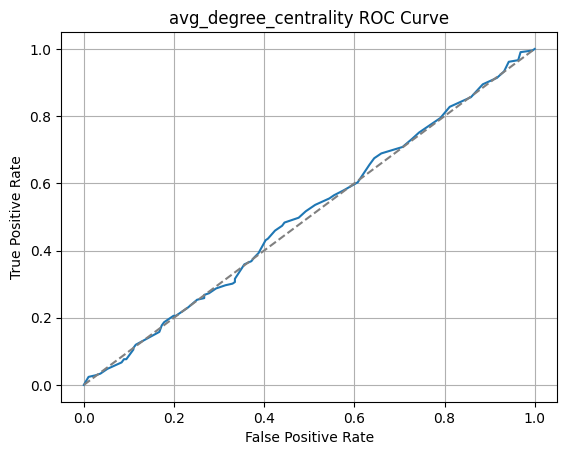

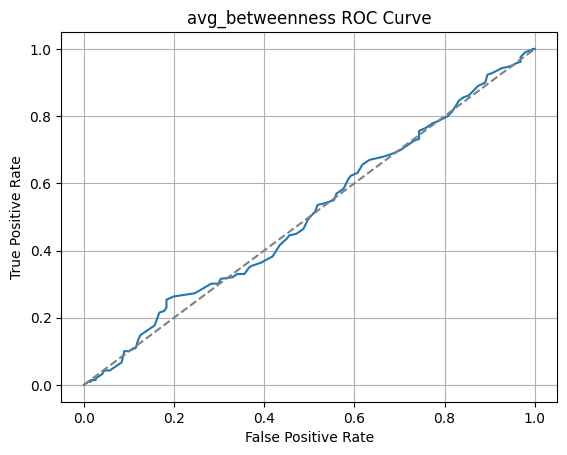

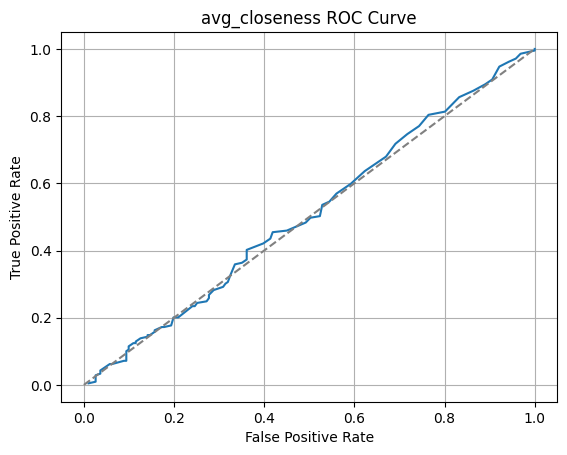

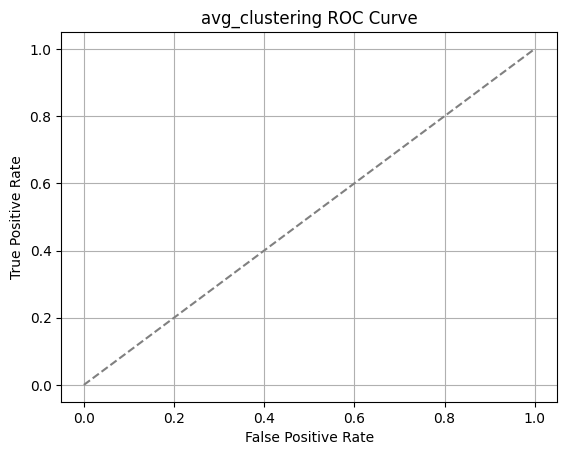

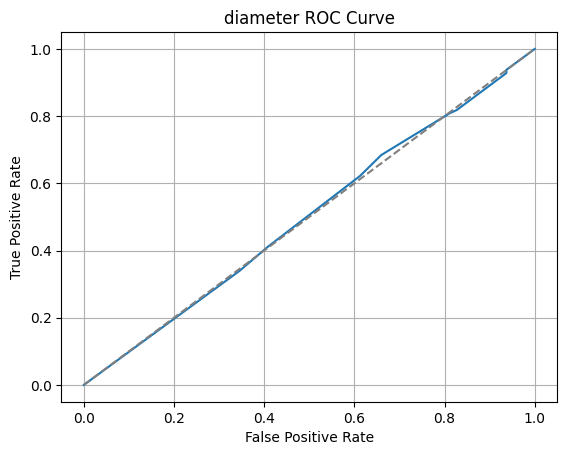

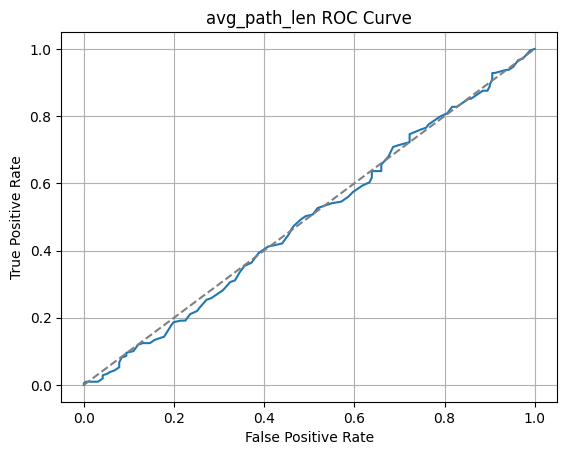

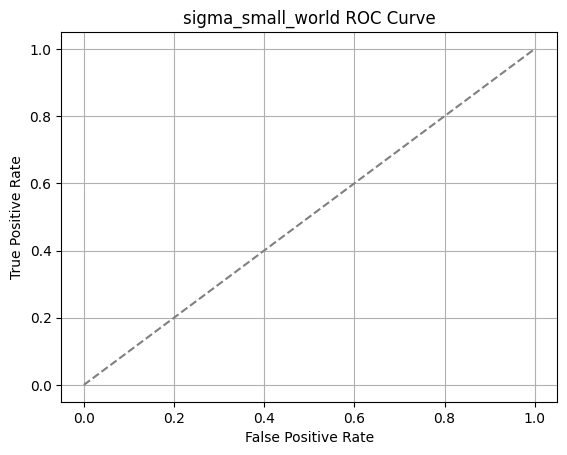

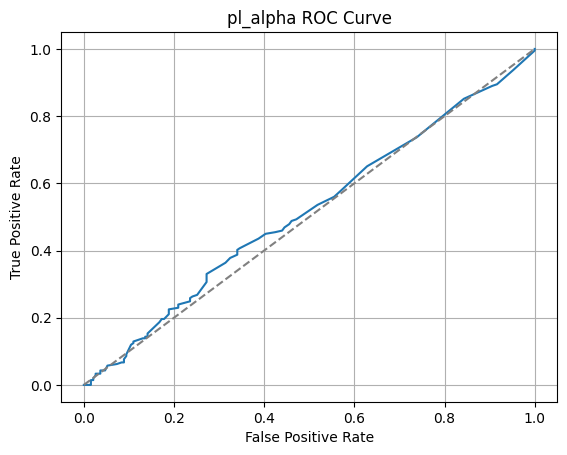

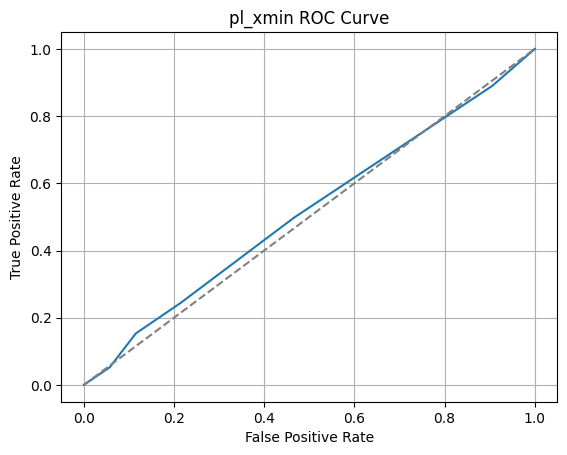



GENERATIONS = 4
THRESHOLDS (pre-confidence score culling)
{'avg_betweenness': {'accuracy': 0.5325,
                     'direction': 'greater',
                     'threshold': np.float64(0.0575784665247152)},
 'avg_closeness': {'accuracy': 0.5325,
                   'direction': 'greater',
                   'threshold': np.float64(0.15539470151317822)},
 'avg_clustering': {'accuracy': 0.5225,
                    'direction': 'less_equal',
                    'threshold': np.float64(0.0)},
 'avg_degree_centrality': {'accuracy': 0.5325,
                           'direction': 'greater',
                           'threshold': np.float64(0.017642127487813207)},
 'avg_path_len': {'accuracy': 0.5325,
                  'direction': 'less_equal',
                  'threshold': np.float64(6.1497214238752695)},
 'diameter': {'accuracy': 0.5225, 'direction': 'greater', 'threshold': 3.92},
 'gen_cov': {'accuracy': 0.7425,
             'direction': 'greater',
             'threshold': np.floa

/tmp/ipython-input-116-4004576428.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)


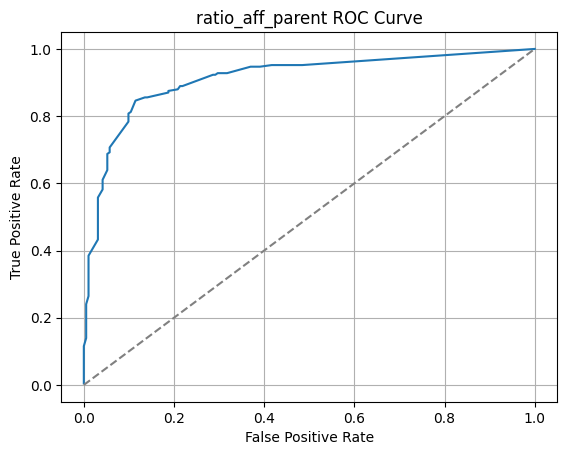

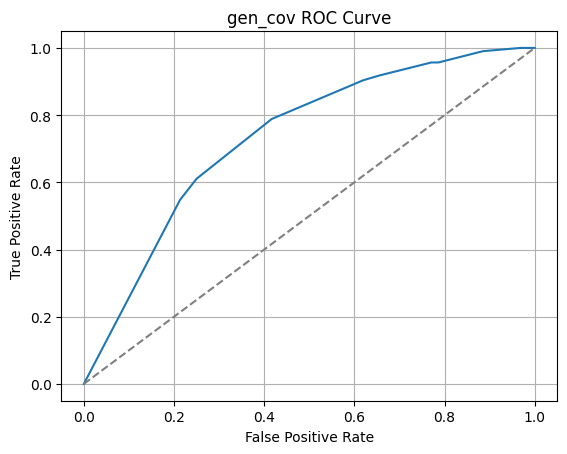

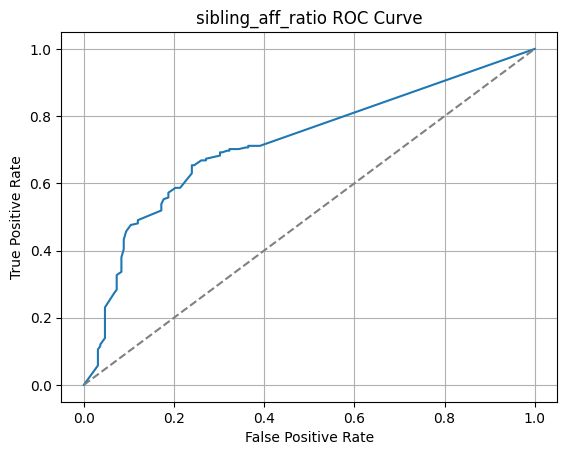

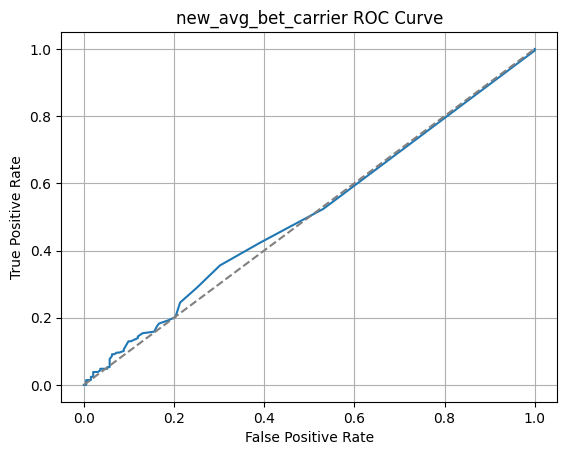

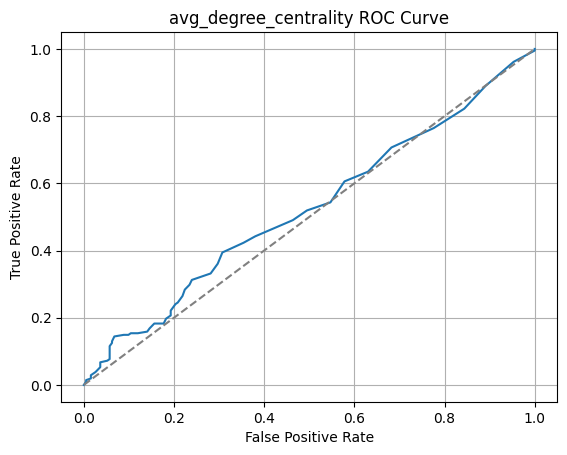

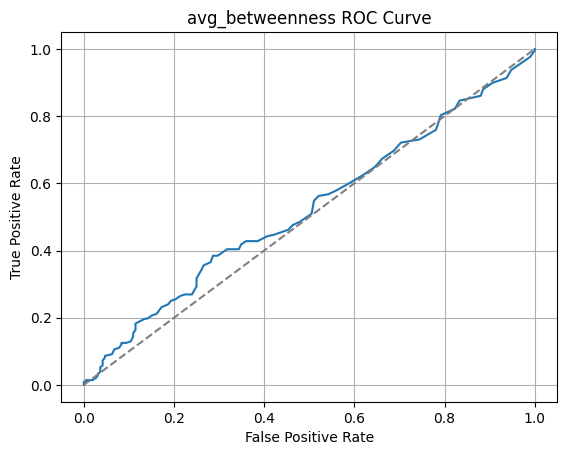

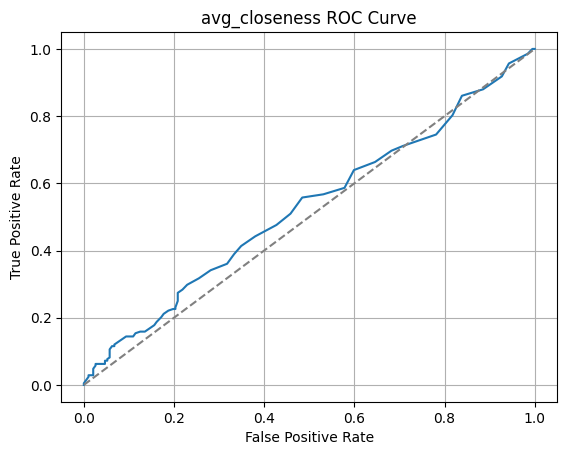

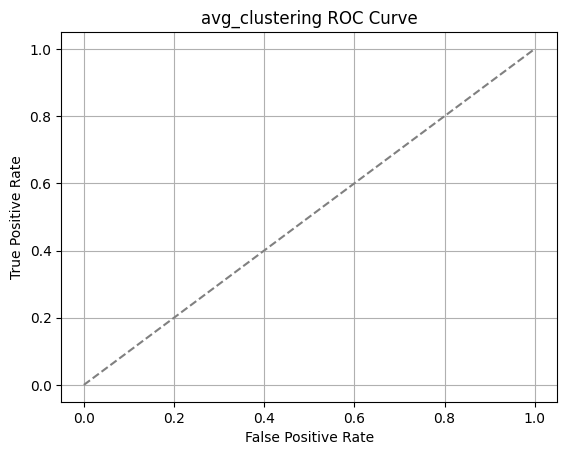

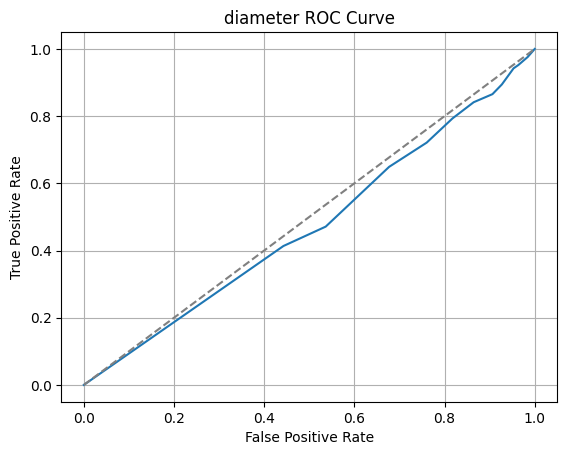

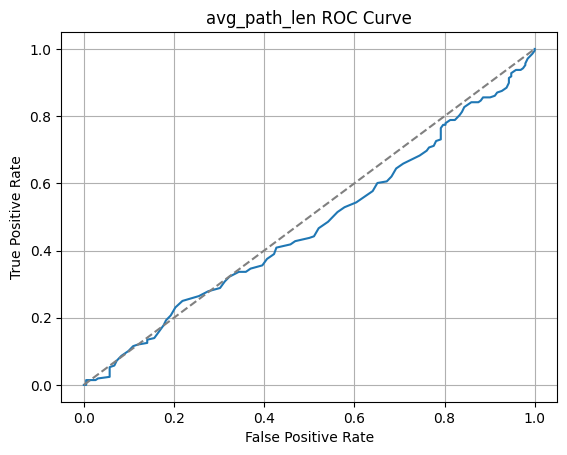

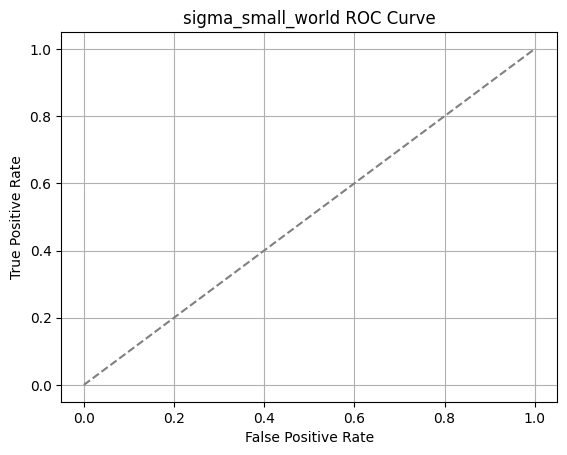

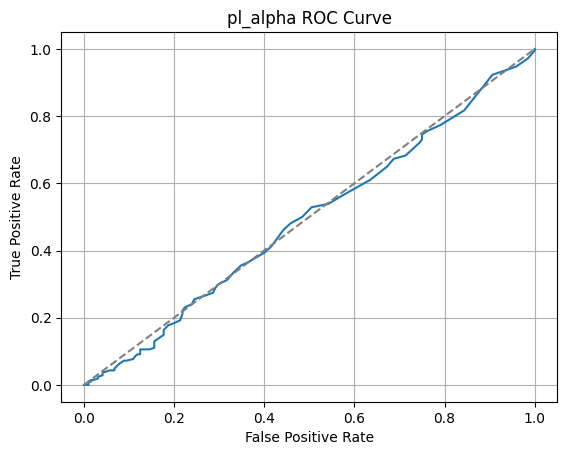

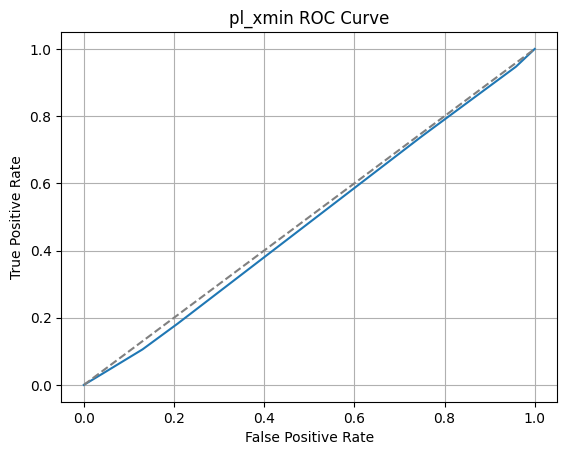



GENERATIONS = 5
THRESHOLDS (pre-confidence score culling)
{'avg_betweenness': {'accuracy': 0.5425,
                     'direction': 'greater',
                     'threshold': np.float64(0.08952967305477724)},
 'avg_closeness': {'accuracy': 0.5375,
                   'direction': 'greater',
                   'threshold': np.float64(0.13992733582108008)},
 'avg_clustering': {'accuracy': 0.52,
                    'direction': 'less_equal',
                    'threshold': np.float64(0.0)},
 'avg_degree_centrality': {'accuracy': 0.5375,
                           'direction': 'greater',
                           'threshold': np.float64(0.033550723817073407)},
 'avg_path_len': {'accuracy': 0.535,
                  'direction': 'less_equal',
                  'threshold': np.float64(7.416307058469602)},
 'diameter': {'accuracy': 0.5325,
              'direction': 'less_equal',
              'threshold': 14.02},
 'gen_cov': {'accuracy': 0.69,
             'direction': 'greater',
      

In [123]:
#to deal with the runtime warnings from sigma calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)



chosen_features = ['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'new_avg_bet_carrier',
                                                'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                                'avg_clustering', 'diameter', 'avg_path_len',
                                                'sigma_small_world', 'pl_alpha', 'pl_xmin']
size_specific_threshold_determination(feature_options= chosen_features,
                                      trials_count= 500,
                                      generation_range= (3,5))

##ROC Plots

/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/tmp/ipython-input-114-3508423671.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.

/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)


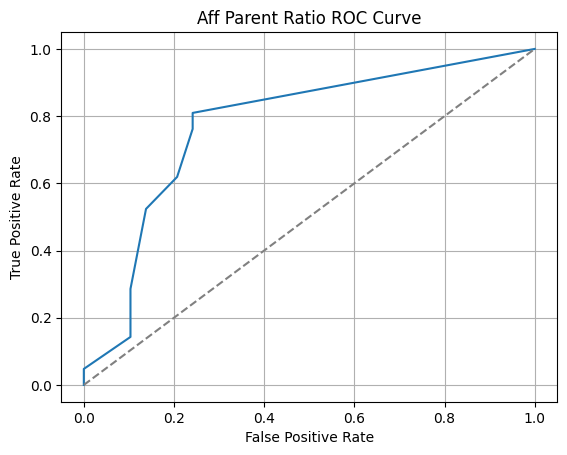

In [115]:
test_feature_df = feature_data_generation(generation_count= 3, trials= 50)
thresh, direct, accur, tpr, fpr = param_best_threshold(test_feature_df['ratio_aff_parent'].values, test_feature_df['actual_mode'].values)
roc_plot(feature= 'Aff Parent Ratio', tpr= tpr, fpr= fpr)
